In [191]:
%pylab inline
import scipy as sp
import pandas as pd
autumn();

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [83]:
data = pd.read_csv('in.csv', index_col=0)
data.head(3)

,a,b,c,d,e
id,,,,,
1,7906633,20,130,0,483
2,NaN,NaN,70,NaN,152
3,19122621,642,20,13283,NaN


In [162]:
log_data = data.copy()
for c in log_data.columns:
    if c != 'd':
        log_data[c] = np.log(log_data[c] + 1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(log_data.dropna())

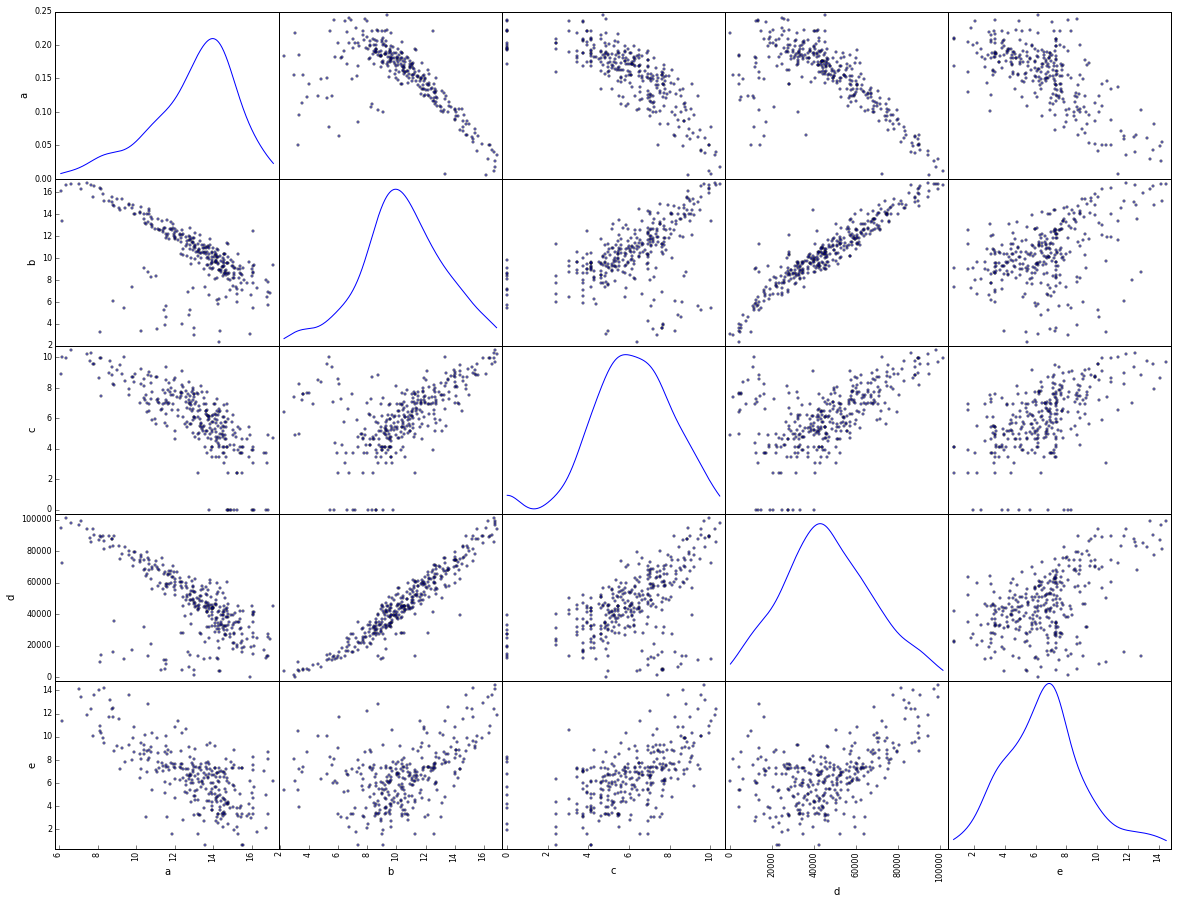

In [175]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(log_data, figsize=(20, 15), diagonal='kde');

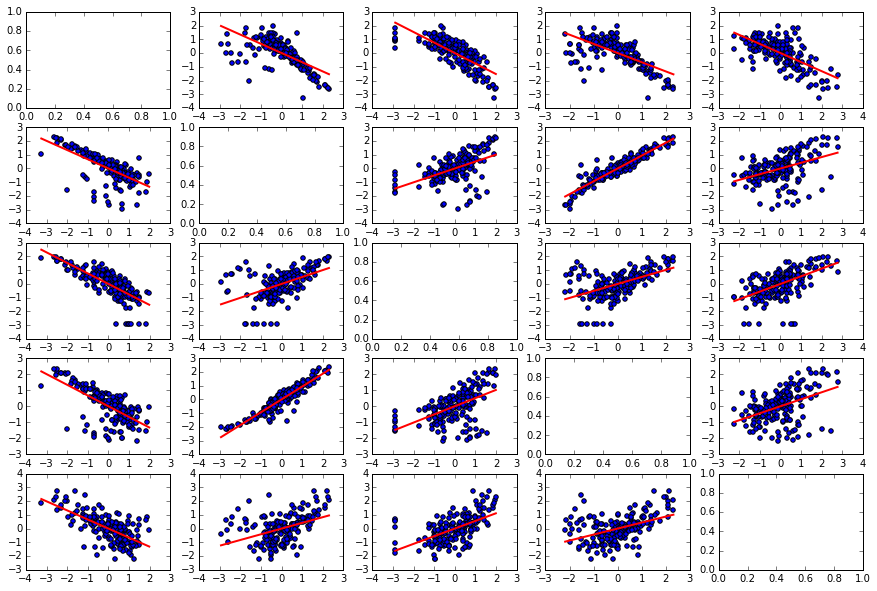

In [207]:
from sklearn.linear_model import LinearRegression
num_features = scaled_data.shape[1]
f, plots = plt.subplots(num_features, num_features)
for row in range(num_features):
    for column in range(num_features):
        if row != column:
            y = scaled_data[:, row]
            x = scaled_data[:, column, np.newaxis]
            f.set_size_inches(15, 10)
            current_plot = plots[row][column]
            current_plot.scatter(x, y)
            l = LinearRegression()
            l.fit(x, y)
            current_plot.plot((x.min(), x.max()),
                              (x.min() * l.coef_ + l.intercept_,
                               x.max() * l.coef_ + l.intercept_),
                              "r-",
                              linewidth=2)

In [208]:
data[np.isnan(data.b) & np.isnan(data.d)]

,a,b,c,d,e
id,,,,,
2,NaN,NaN,70,NaN,152
26,7630769,NaN,230,NaN,28
31,193603,NaN,475,NaN,NaN
32,545039,NaN,10,NaN,4
203,406849,NaN,650,NaN,2253


0    179
1    187
2     65
3      8
dtype: int64

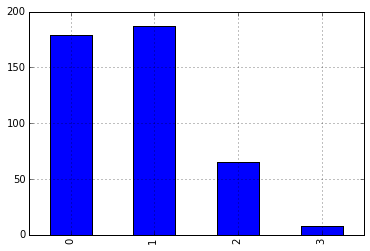

In [84]:
missing_values = data.isnull().sum(axis=1)
missing_groups = missing_values.groupby(missing_values.values).size()
missing_groups.plot(kind='bar')
missing_groups

In [176]:
data[data.isnull().sum(axis=1) == 3]

,a,b,c,d,e
id,,,,,
2,NaN,NaN,70,NaN,152
31,193603,NaN,475,NaN,NaN
128,NaN,NaN,60,32516,NaN
157,6986,NaN,NaN,35969,NaN
213,NaN,NaN,325,53715,NaN
252,NaN,NaN,NaN,59587,8
343,NaN,NaN,NaN,41941,780
398,NaN,NaN,NaN,35472,132


In [85]:
data.describe()

,a,b,c,d,e
count,350.000000,375.000000,368.000000,404.000000,357.000000
mean,1931520.328571,872379.480000,2188.179348,46544.349010,35593.725490
std,3706373.503441,2957194.665734,4620.451613,21411.213027,181819.857097
min,444.000000,9.000000,0.000000,0.000000,1.000000
25%,111216.250000,6415.500000,130.000000,32090.250000,132.000000
50%,632400.000000,32700.000000,475.000000,44939.500000,784.000000
75%,1970495.750000,222177.500000,1800.000000,60289.250000,2516.000000
max,27057179.000000,21245399.000000,35000.000000,101295.000000,1918620.000000


In [86]:
extended_data = data.copy()
for c in extended_data.columns:
    extended_data["log_{}".format(c)] = np.log(1 + data[c])

In [87]:
data.shape

(439, 5)

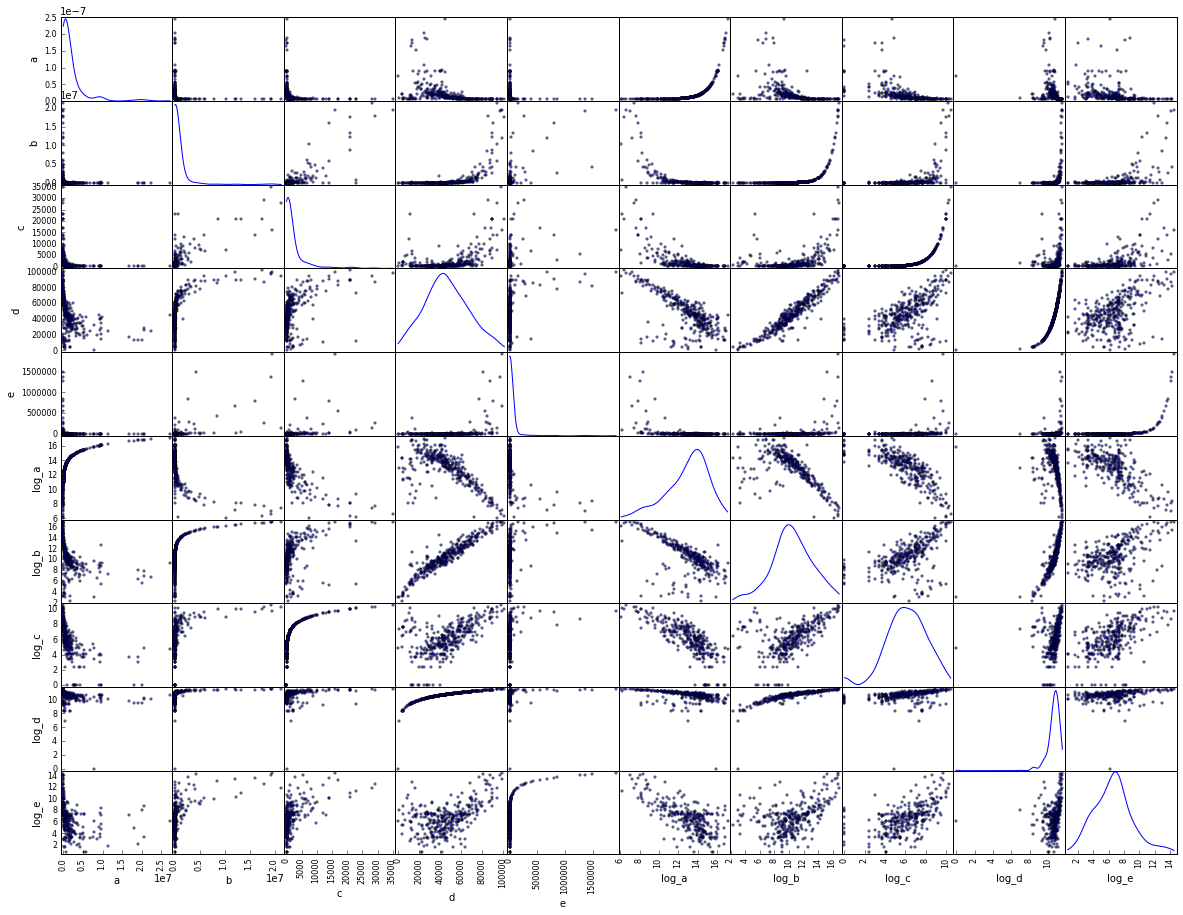

In [88]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(extended_data, figsize=(20, 15), diagonal='kde');

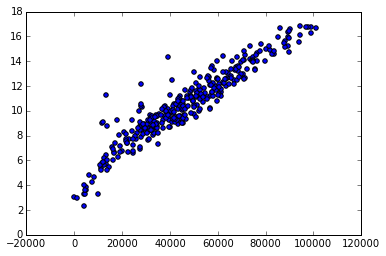

In [89]:
scatter(extended_data.d, extended_data.log_b);

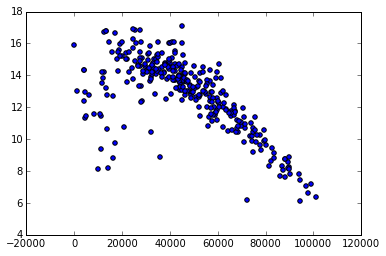

In [90]:
scatter(extended_data.d, extended_data.log_a);

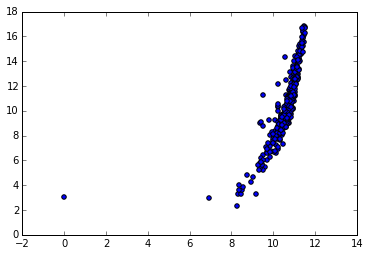

In [91]:
scatter(extended_data.log_d, extended_data.log_b);

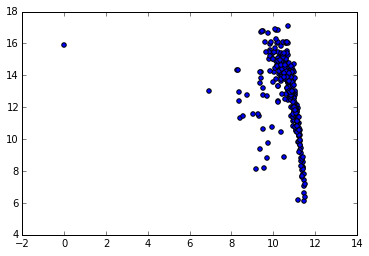

In [92]:
scatter(extended_data.log_d, extended_data.log_a);

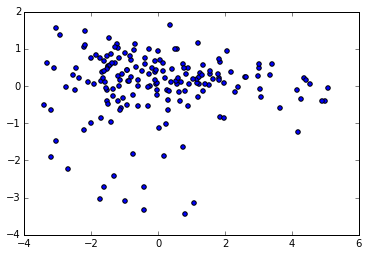

In [210]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_2d = pca.fit_transform(scaled_data)
scatter(*(data_2d.T));

# Solution:

In [360]:
p = data.dropna().iloc[13]
p

a    4355929
b       8161
c         50
d      34743
e          4
Name: 45, dtype: float64

In [361]:
p[0] = np.NaN
p[1] = np.NaN
p[2] = np.NaN
# p[3] = np.NaN
# p[4] = np.NaN
p

a      NaN
b      NaN
c      NaN
d    34743
e        4
Name: 45, dtype: float64

-1.70628503e+02  -4.40527517e+00   1.98912198e+02  -2.60563381e-02
   2.22166515e+02

In [382]:
pca = PCA(n_components=5)
pca.fit(scaled_data)
point_mask = np.array([1,1,1,0,1], dtype=bool)

def transform_log(X):
    return X * ~point_mask + np.log1p(X * point_mask)

def inverse_transform_log(X):
    return X * ~point_mask + np.expm1(X * point_mask)

def fill(point):
    log_point = transform_log(np.nan_to_num(point))
    X = scaler.transform(log_point)
    mask = ~np.isnan(point).values
    X = X * mask
    num_components = mask.sum()
    V = pca.components_[:num_components]
    K = np.linalg.lstsq((V * mask).T, X.T)[0].T
    log_predict = scaler.inverse_transform(X + (~mask * (K.dot(V))))
    return inverse_transform_log(log_predict)
[p, fill(p)]

[a      NaN
 b      NaN
 c      NaN
 d    34743
 e        4
 Name: 45, dtype: float64,
 array([  1.37614070e+07,   9.02694104e+03,   9.57367966e+00,
          3.47430000e+04,   4.00000000e+00])]

In [510]:
class Filler:
    def __init__(self):
        self._pca = PCA()
        self._scaler = StandardScaler()
        self._mask = np.array([1,1,1,0,1], dtype=bool)
        # self._mask = np.array([0,0,0,0,0], dtype=bool)
        # self._mask = np.array([1,1,0,0,1], dtype=bool)
    def _log_transform(self, X):
        return X * ~self._mask + np.log1p(X * self._mask)
    def _inverse_log_transform(self, X):
        return X * ~self._mask + np.expm1(X * self._mask)
    def transform(self, X):
        return self._scaler.transform(self._log_transform(X))
    def inverse_transform(self, X):
        return self._inverse_log_transform(self._scaler.inverse_transform(X))
    def fit(self, X):
        self._pca.fit(self._scaler.fit_transform(self._log_transform(X)))
    def predict_point(self, point):
        mask = ~np.isnan(point)
        n_components = mask.sum()
        if n_components == mask.shape[0]:
            return point
        filled_point = self.transform(np.nan_to_num(point))
        filled_point[~mask] = 0
        basis = self._pca.components_[:n_components]
        coefficients = np.linalg.lstsq((basis * mask).T, filled_point.T)[0].T
        prediction = filled_point + (~mask * (coefficients.dot(basis)))
        return self.inverse_transform(prediction)
    def predict(self, X):
        answer = np.zeros(X.shape)
        for idx, point in enumerate(X):
            answer[idx] = self.predict_point(point)
        return answer

def get_test_data(data, threshold):
    result = data.copy().astype(float)
    result.iloc[np.random.sample(result.shape) < threshold] = np.NaN
    return result

def test_filler(filler, data, threshold):
    answer = data
    test_data = get_test_data(data, threshold)
    filler_answer = filler.predict(test_data.values)
    return ((filler.transform(filler_answer) - filler.transform(answer))**2).mean()
    
f = Filler()
train_data = data.dropna()
p = data.ix[2]
f.fit(train_data)
# test_filler(f, train_data, threshold=0.2)

In [514]:
test_data = get_test_data(data, 0.15)
prediction = pd.DataFrame(f.predict(test_data.values))

In [515]:
prediction.describe()

,0,1,2,3,4
count,4.390000e+02,4.390000e+02,4.390000e+02,439.000000,4.390000e+02
mean,1.236013e+34,1.918733e+10,1.344151e+52,44139.051300,5.821843e+25
std,2.589734e+35,4.019545e+11,2.816309e+53,32030.831704,1.219812e+27
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-246381.913291,-1.000000e+00
25%,7.346700e+04,5.978000e+03,1.000000e+02,31427.664670,7.316693e+01
50%,5.399671e+05,3.340400e+04,4.750000e+02,44901.000000,6.832388e+02
75%,2.170409e+06,2.200051e+05,2.561514e+03,59865.000000,5.765500e+03
max,5.426095e+36,8.421886e+12,5.900822e+54,189194.874399,2.555789e+28


In [516]:
data.describe()

,a,b,c,d,e
count,350.000000,375.000000,368.000000,404.000000,357.000000
mean,1931520.328571,872379.480000,2188.179348,46544.349010,35593.725490
std,3706373.503441,2957194.665734,4620.451613,21411.213027,181819.857097
min,444.000000,9.000000,0.000000,0.000000,1.000000
25%,111216.250000,6415.500000,130.000000,32090.250000,132.000000
50%,632400.000000,32700.000000,475.000000,44939.500000,784.000000
75%,1970495.750000,222177.500000,1800.000000,60289.250000,2516.000000
max,27057179.000000,21245399.000000,35000.000000,101295.000000,1918620.000000


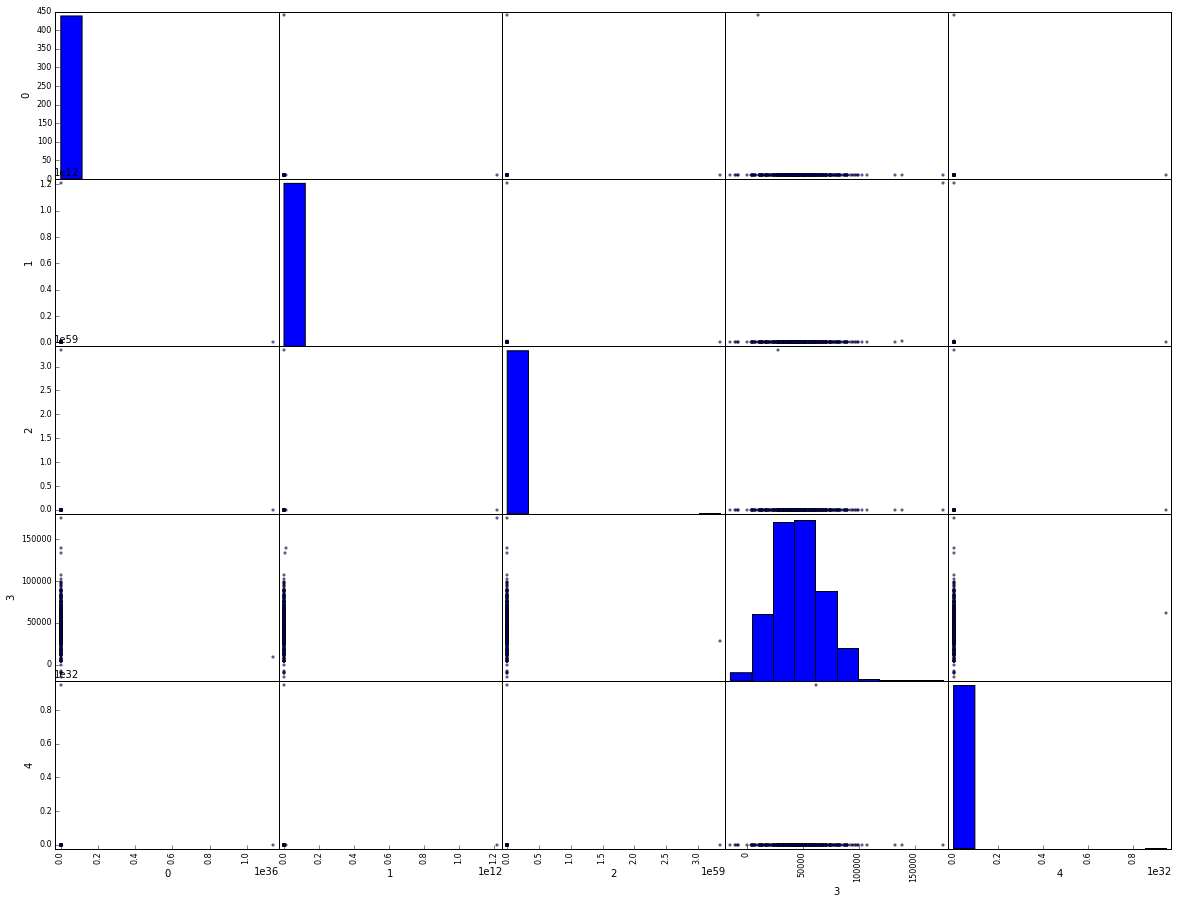

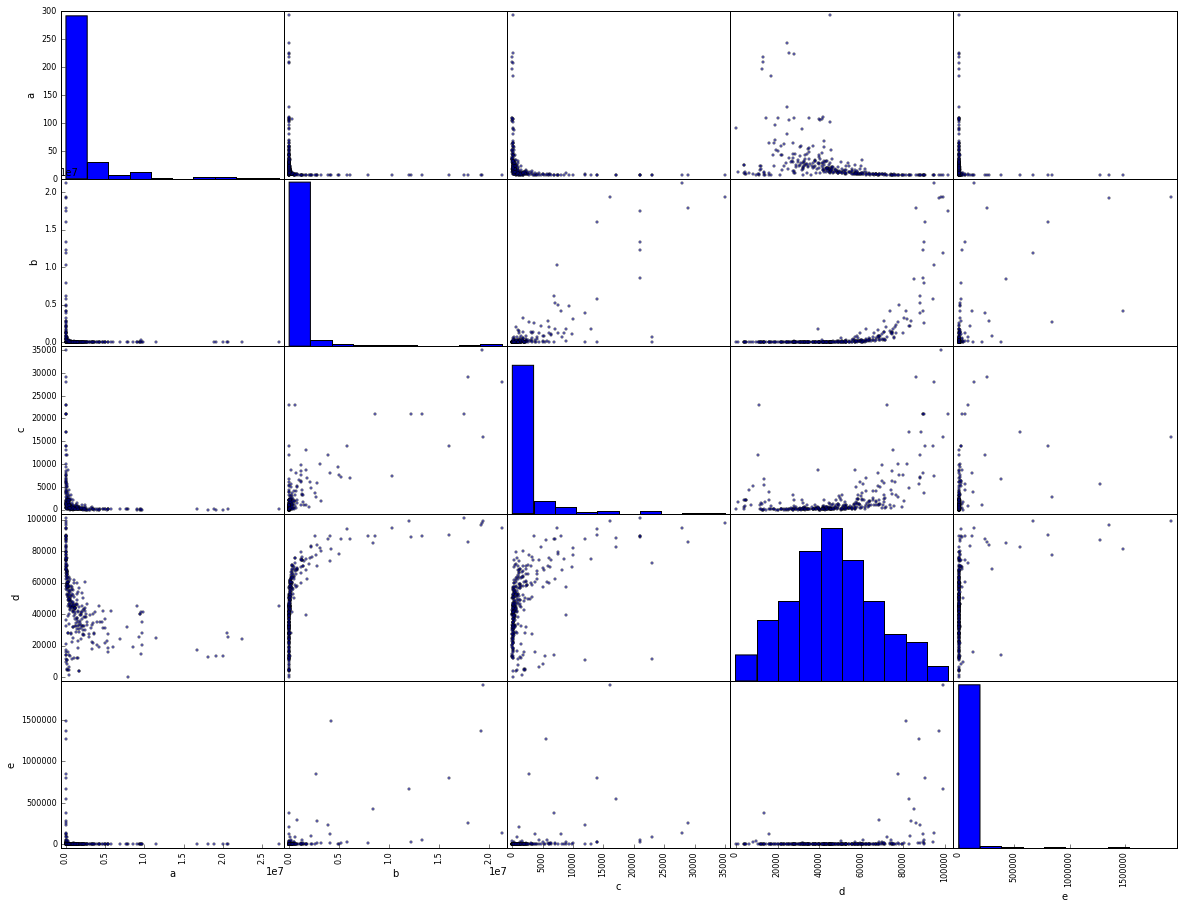

In [512]:

scatter_matrix(prediction, figsize=(20, 15));
show()
scatter_matrix(data, figsize=(20, 15));


In [489]:
f._scaler.mean_

array([  1.29780375e+01,   1.04786971e+01,   6.07945133e+00,
         4.57383966e+04,   6.49053505e+00])

In [428]:
default_logs = 4.8586939141835435e+51
no_logs = 3.323284235257788

In [496]:
f._pca.explained_variance_ratio_

array([ 0.69320072,  0.16775189,  0.08893624,  0.03719793,  0.01291322])

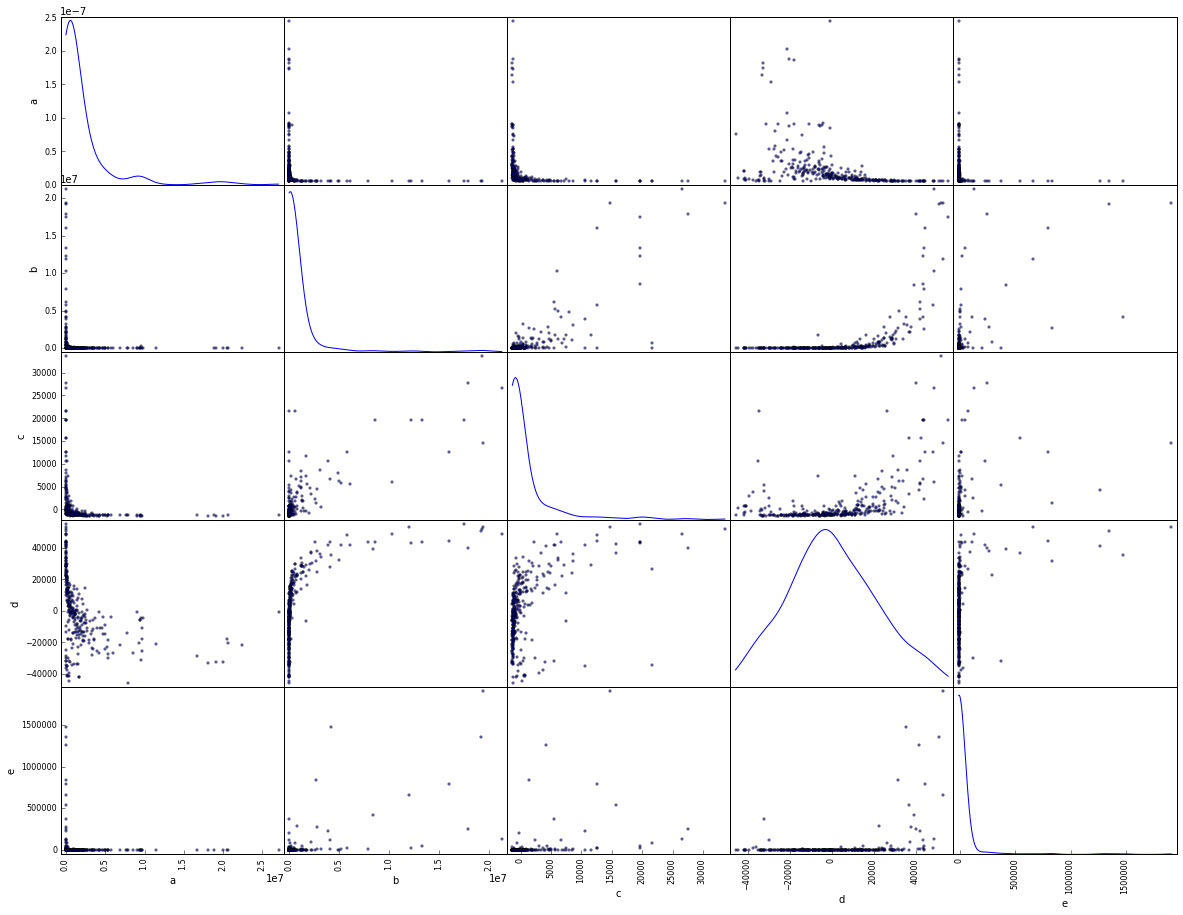

In [133]:
scatter_matrix(data - initial_center, figsize=(20, 15), diagonal='kde');